# Python and Sionna RT Environment Config

In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')



# Set random seed for reproducibility
# sionna.config.seed = 42

In [2]:
try:
    import sionnautils
except ImportError as e:
    # Install Sionna if package is not already installed
    !pip install git+https://github.com/sdrangan/wirelesscomm.git
    import sionnautils

import numpy as np
import matplotlib.pyplot as plt
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sionnautils.miutils import CoverageMapPlanner
from matplotlib.colors import ListedColormap
from tqdm import tqdm
tf.keras.backend.clear_session()

In [3]:
scene = load_scene("Denver/denver.xml")

In [4]:


grid_size = 1

# Set a bounding box in the center bbox = [xmin, xmax, ymin, ymax]
L_NS = 3700
W_WE = 2900
bbox = [-W_WE/2,W_WE/2,-L_NS/2,L_NS/2]

# cm = CoverageMapPlanner(scene._scene, grid_size=grid_size, bbox=bbox)
cm = CoverageMapPlanner(scene._scene, grid_size=grid_size)
cm.set_grid()
cm.compute_grid_attributes()

In [5]:
# Define a custom color map with RGB values

# colors = ['lightgray', 'lightblue', 'brown']
# cmap = ListedColormap(colors)

# outdoor = (cm.bldg_grid==False) & cm.in_region
# building = (cm.bldg_grid) & cm.in_region
# point_type = outdoor + 2*building
# point_type = point_type.astype(int)
# point_type = np.flipud(point_type)


colors = ['lightgray', 'brown']
cmap = ListedColormap(colors)

# outdoor = (cm.bldg_grid==False) & cm.in_region
building = (cm.bldg_grid) & cm.in_region
point_type = building
point_type = point_type.astype(int)
point_type = np.flipud(point_type)

In [12]:
"""
add TX, only 1 gnB station in the scene
"""
nlos_cdf = []
los_cdf = []

n_sim = 200
for sim in tqdm(range(n_sim), desc="Simulations"):
    ntx = 1
    height_above_roof = 5
    height_above_ground = 10

    locations = np.argwhere(np.ones(cm.bldg_grid.shape, dtype=bool)) # anywhere


    tx_ind = locations[np.random.choice(locations.shape[0], ntx, replace=False)]

    tx_x = cm.x[tx_ind[:,1]]
    tx_y = cm.y[tx_ind[:,0]]
    # tx_z = cm.zmax_grid[tx_ind[:,0], tx_ind[:,1]] + height_above_roof
    tx_z = np.where(
        cm.bldg_grid[tx_ind[:, 0], tx_ind[:, 1]],
        cm.zmax_grid[tx_ind[:, 0], tx_ind[:, 1]] + height_above_roof,
        cm.zmin_grid[tx_ind[:, 0], tx_ind[:, 1]] + height_above_ground
    )

    tx_pos = np.column_stack((tx_x, tx_y, tx_z))

    """
    add RX, 100 ntn_rx and 3 tn_rx randomly located in the scene, 
    set different heights according to its above ground or roof
    """


    ntn_rx = 200
    tn_rx = 0


    num_ntn_building = int(0.7 * ntn_rx)
    num_ntn_outdoor = ntn_rx - num_ntn_building

    height_above_ground = 1.5
    height_above_roof   = 1.0 
    # locations = np.argwhere((cm.bldg_grid==False) & cm.in_region)
    # locations = np.argwhere( cm.in_region)

    # locations = np.argwhere(np.ones(cm.bldg_grid.shape, dtype=bool)) # anywhere
    # rx_ntn_ind = locations[np.random.choice(locations.shape[0], ntn_rx, replace=False)]


    locations_building = np.argwhere(cm.bldg_grid & cm.in_region)
    locations_outdoor = np.argwhere(np.ones(cm.bldg_grid.shape, dtype=bool)) # anywhere

    rx_ntn_building_ind = locations_building[np.random.choice(locations_building.shape[0], num_ntn_building, replace=False)]
    rx_ntn_outdoor_ind = locations_outdoor[np.random.choice(locations_outdoor.shape[0], num_ntn_outdoor, replace=False)]
    rx_ntn_ind = np.vstack((rx_ntn_building_ind, rx_ntn_outdoor_ind))


    rx_ntn_x = cm.x[rx_ntn_ind[:,1]]
    rx_ntn_y = cm.y[rx_ntn_ind[:,0]]
    # rx_ntn_z = cm.zmin_grid[rx_ntn_ind[:,0], rx_ntn_ind[:,1]] + height_above_ground
    rx_ntn_z = np.where(
        cm.bldg_grid[rx_ntn_ind[:, 0], rx_ntn_ind[:, 1]],
        cm.zmax_grid[rx_ntn_ind[:, 0], rx_ntn_ind[:, 1]] + height_above_roof,
        cm.zmin_grid[rx_ntn_ind[:, 0], rx_ntn_ind[:, 1]] + height_above_ground
    )

    rx_ntn_pos = np.column_stack((rx_ntn_x, rx_ntn_y, rx_ntn_z))




    rx_tn_ind = locations[np.random.choice(locations.shape[0], tn_rx, replace=False)]
    rx_tn_x = cm.x[rx_tn_ind[:,1]]
    rx_tn_y = cm.y[rx_tn_ind[:,0]]
    # rx_tn_z = cm.zmin_grid[rx_tn_ind[:,0], rx_tn_ind[:,1]] + height_above_ground
    rx_tn_z = np.where(
        cm.bldg_grid[rx_tn_ind[:, 0], rx_tn_ind[:, 1]],
        cm.zmax_grid[rx_tn_ind[:, 0], rx_tn_ind[:, 1]] + height_above_roof,
        cm.zmin_grid[rx_tn_ind[:, 0], rx_tn_ind[:, 1]] + height_above_ground
    )

    rx_tn_pos = np.column_stack((rx_tn_x, rx_tn_y, rx_tn_z))


    extent = extent=[cm.x[0], cm.x[-1], cm.y[0], cm.y[-1]]
    # plt.imshow(point_type, cmap=cmap, interpolation='nearest', extent=extent)
    # plt.scatter(tx_pos[:,0], tx_pos[:,1], color='blue', marker='o', s=5, label='Tx')
    # plt.scatter(rx_tn_pos[:,0], rx_tn_pos[:,1], color='green', marker='x', s=5, label='tn_Rx')
    # plt.scatter(rx_ntn_pos[:,0], rx_ntn_pos[:,1], color='red', marker='x', s=5, label='ntn_Rx')
    # plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
    def satellite_projection(azimuth, elevation, distance, L, W):
        """
        Calculate the satellite coordinates above the region and project them onto the boundary if outside.
        
        :param azimuth: Azimuth angle (degrees)
        :param elevation: Elevation angle (degrees)
        :param distance: Distance from the satellite to the origin (m)
        :param L: North-South length of the region (m)
        :param W: East-West width of the region (m)
        :return: (x_proj, y_proj, z_proj) where these are the adjusted satellite coordinates.
        """
        # Convert angles to radians
        azimuth_rad = np.radians(azimuth)
        elevation_rad = np.radians(elevation)
        
        # Calculate satellite Cartesian coordinates
        x = distance * np.cos(elevation_rad) * np.sin(azimuth_rad)
        y = distance * np.cos(elevation_rad) * np.cos(azimuth_rad)
        z = distance * np.sin(elevation_rad)
        
        # Define boundary limits
        x_min, x_max = -W / 2, W / 2
        y_min, y_max = -L / 2, L / 2
        
        # Adjust coordinates based on boundary conditions
        x_proj, y_proj, z_proj = x, y, z
        if x < x_min:
            x_proj = x_min
        elif x > x_max:
            x_proj = x_max
        
        if y < y_min:
            y_proj = y_min
        elif y > y_max:
            y_proj = y_max
        
        # Calculate the projected height on the boundary
        if x != 0 or y != 0:
            ratio = min((x_proj - 0) / (x - 0) if x != 0 else float('inf'), (y_proj - 0) / (y - 0) if y != 0 else float('inf'))
            if 0 < ratio <= 1:
                z_proj = ratio * z
        
        return x_proj, y_proj, z_proj

    # Example usage
    azimuth = 0  # Azimuth angle (degrees)
    elevation = 60  # Elevation angle (degrees)

    # azimuth = np.random.uniform(0, 360)  # Random azimuth angle (degrees)  # Azimuth angle (degrees)
    # elevation = np.random.uniform(25, 90)
    distance = 500e3  # Satellite distance (m)


    x_proj, y_proj, z_proj = satellite_projection(azimuth, elevation, distance, L_NS, W_WE)
    ntn_look_pos = np.array([x_proj, y_proj, z_proj])
    """
    Configure antennas and add them to the scene

    """

    # Frequency in Hz
    fc = 10e9

    scene.frequency = fc # in Hz; implicitly updates RadioMaterials
    scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element

    scene.tx_array = PlanarArray(
        num_rows=8, num_cols=8,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        polarization="V",
        pattern="tr38901"
    )

    # Configure antenna array for all receivers
    scene.rx_array = PlanarArray(
        num_rows=2, num_cols=2,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        polarization="cross",
        pattern="dipole"
        # polarization="V",
        # pattern="tr38901"
    )

    # Remove all previous receivers
    for rx_name in scene.receivers:
        scene.remove(rx_name)

    # Remove all previous transmitters
    for tx_name in scene.transmitters:
        scene.remove(tx_name)

    # Add transmitter
    for i in range(ntx):
        tx = sionna.rt.Transmitter(name=f"tx-{i}",
                    position=tx_pos[i])
        scene.add(tx)
        tx.look_at([0,-1550,20])

    for i in range(tn_rx):
        rx = sionna.rt.Receiver(name=f"tn-{i}",
                        color = [0.0, 1.0, 0.0],
                    position=rx_tn_pos[i])
        scene.add(rx)
        rx.look_at([0,1550,300e3])

    for i in range(ntn_rx):
        rx = sionna.rt.Receiver(name=f"ntn-{i}",
                        color = [1.0, 0.0, 0.0],
                    position=rx_ntn_pos[i])
        scene.add(rx)
        rx.look_at(ntn_look_pos)

    from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset





    subcarrier_spacing = 15e3
    fft_size = 48
    threshold=1e-9

    """
    Computes the OFDM channel frequency response based on ray-tracing paths.

    Only Reflection = True, discard defraction

    Parameters:
    - scene: The simulation scene containing transmitters and receivers.
    - subcarrier_spacing (float): The spacing between subcarriers in Hz.
    - fft_size (int): The number of subcarriers in the OFDM system.
    - threshold (float, optional): set to a very small number to neglect RXs that without ray to TX .

    Returns:
    - channels (dict): A dictionary mapping each receiver name to its corresponding OFDM channel response.
    - paths: The computed ray-tracing paths.
    - h_freq (numpy.ndarray): The complete OFDM channel frequency response tensor.
    """
    paths = scene.compute_paths(
        max_depth=3, num_samples=1e6, diffraction=False, scattering=False, check_scene=False
    )
    paths.normalize_delays = False
    # paths.normalize_delays = False

    a, tau = paths.cir()  # a: shape [batch, num_rx, N_tx, num_paths]
    tau_data = tau[0,:,:,0]
    # OFDM Channels, Compute the frequency response of the channel at frequencies.

    frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

    h_freq = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss



    rx_names = [rx.name for rx in scene.receivers.values()]
    # channels = {name: h_freq[:, i:i+1, :, :, :, :, :] for i, name in enumerate(rx_names)}
    channels = {}


    energy_per_pair = np.sum(np.abs(h_freq)**2, axis=(2, 4, 5, 6)) # sum over rx_ant, tx_ant, time, freq    
    energy_per_pair_a = np.sum(np.abs(a)**2, axis=(2, 4, 5, 6))
    # energy_per_pair now has shape [batch, num_rx, num_tx].

    # Option 1: Sum again over batch dimension => shape [num_rx, num_tx]
    energy_per_pair = np.sum(energy_per_pair, axis=0)
    # energy_per_pair_a = np.sum(energy_per_pair, axis=0)
    # Build final dictionary
    for i, name in enumerate(rx_names):
        # For each Rx 'i', decide which Tx indices to keep
        # keep_tx = np.where(energy_per_pair[i, :] > threshold)[0]
        keep_tx = np.where(energy_per_pair[i, :] > 0)[0]
        
        if len(keep_tx) == 0:
            # No transmitters passed threshold for this Rx => skip or store empty
            continue
        
        # Extract the subset of h_freq along the Tx dimension
        # h_freq shape: [batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size]
        # We keep only the i-th Rx and the Tx indices in keep_tx:
        # sub_h = h_freq[:, i:i+1, :, keep_tx, :, :, :]  # shape [batch, 1, rx_ant, M, tx_ant, time_steps, fft_size]
        sub_h = tf.gather(h_freq, keep_tx, axis=3)[:, i:i+1, :, :, :, :, :]

        channels[name] = sub_h

    selected_indices = [i for i, name in enumerate(rx_names) if name in channels]
    tau = paths.tau.numpy()
    tau_selected = tau[0, selected_indices, :, :]
    los_selected = (tau_selected[:, :, 0] > 0)
    outage_selected = np.all(tau_selected < 0, axis=2)
    num_nlos = np.sum((outage_selected == False) & (los_selected == False))
    num_los = np.sum(los_selected)

    pct_nlos = num_nlos/ntn_rx
    pct_los = num_los/ntn_rx
    nlos_cdf.append(pct_nlos)
    los_cdf.append(pct_los)









Simulations: 100%|██████████| 200/200 [06:52<00:00,  2.06s/it]


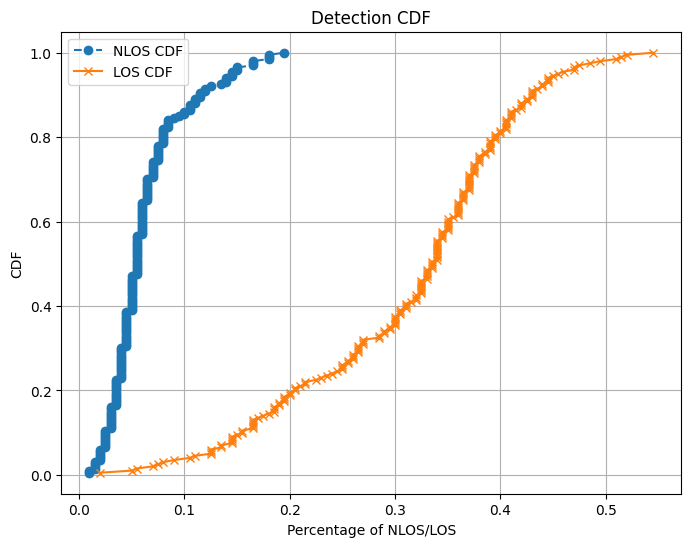

In [ ]:
nlos_cdf_sorted = np.sort(nlos_cdf)
los_cdf_sorted = np.sort(los_cdf)
cdf_nlos = np.arange(1, len(nlos_cdf_sorted) + 1) / len(nlos_cdf_sorted)
cdf_los = np.arange(1, len(los_cdf_sorted) + 1) / len(los_cdf_sorted)

plt.figure(figsize=(8, 6))
plt.plot(nlos_cdf_sorted, cdf_nlos, label="NLOS CDF", linestyle='--', marker='o')
plt.plot(los_cdf_sorted, cdf_los, label="LOS CDF", linestyle='-', marker='x')

plt.xlabel("Percentage of NLOS/LOS")
plt.ylabel("CDF")
plt.title("Detection CDF")
plt.legend()
plt.grid(True)

plt.show()

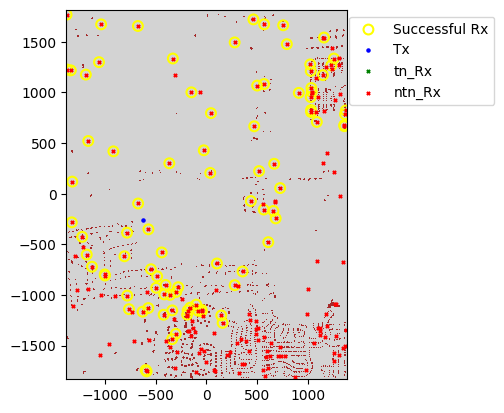

In [14]:
successful_rx_positions = []
for rx_name in channels.keys():
    rx = scene.receivers[rx_name]
    successful_rx_positions.append(rx.position[:2])

if successful_rx_positions:
    successful_rx_positions = np.array(successful_rx_positions)
    plt.scatter(successful_rx_positions[:, 0], successful_rx_positions[:, 1],
                edgecolor='yellow', facecolor='none', marker='o', s=50, linewidth=1.5, label='Successful Rx')
extent = extent=[cm.x[0], cm.x[-1], cm.y[0], cm.y[-1]]
plt.imshow(point_type, cmap=cmap, interpolation='nearest', extent=extent)
plt.scatter(tx_pos[:,0], tx_pos[:,1], color='blue', marker='o', s=5, label='Tx')
plt.scatter(rx_tn_pos[:,0], rx_tn_pos[:,1], color='green', marker='x', s=5, label='tn_Rx')
plt.scatter(rx_ntn_pos[:,0], rx_ntn_pos[:,1], color='red', marker='x', s=5, label='ntn_Rx')
plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1))
plt.show()
